# A meshing tutorial that uses PyDistmesh 

In [1]:
# Some imports
import numpy as np
import os

# Import csi
import csi.insar as insar
import csi.fault3D as rectflt
import csi.TriangularPatches as triangleflt
import csi.geodeticplot as geoplt

# Some plotting imports
import matplotlib.pyplot as plt

# Distmesh
import distmesh as dm

# Shut up warnings
import warnings
warnings.simplefilter("ignore") 

# Some styling changes
from pylab import rcParams
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.labelsize'] = 'x-large'
rcParams['axes.titlesize'] = 'xx-large'
rcParams['axes.titleweight'] = 'bold'

# Reference
lon0=33.0
lat0=40.8

## Creating a fault object

In [2]:
# Deal with the surface expression of the fault
intrace = os.path.join(os.getcwd(),'DataAndModels/NAF.xy')

# Create the fault
naf = triangleflt('North Anatolian Fault', lon0=lon0, lat0=lat0)
naf.file2trace(intrace, header=0)
naf.discretize(every=0.5)

# For later plotting
naf.color='k'
naf.linewidth=3

---------------------------------
---------------------------------
Initializing fault North Anatolian Fault


## Some elements for Distmesh

Here we constrain the top of the fault to be at at the surface. 

In [6]:
# Cumdistance computes the distance along the fault trace to make a reference frame (depth, along strike)
alongStrike = naf.cumdistance(discretized=True)

# These are the bounds of the box within which we will mesh the fault
depth_min = 0. # set limits in depth to the fault
depth_max = 20.

# The dimension along depth
step_dip = 0.1
alongDip = np.arange(depth_min, depth_max, step_dip) # depth axis

# This is an increasing depth factor
depth_factor = 5.

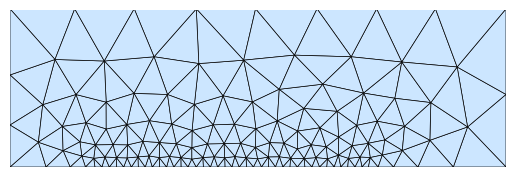

In [9]:
# Make a polynome with the contours
pv = [(s,depth_min*depth_factor) for s in alongStrike] # horizontal line at depth_min
pv += [(alongStrike[-1],d) for d in np.arange(depth_min*depth_factor, depth_factor*depth_max, step_dip)] # we add the vertical line  at the end of the strike
pv += [(s,depth_factor*depth_max) for s in alongStrike[::-1]] # and the horizontal line at depth_max
pv += [(alongStrike[0],d) for d in np.arange(depth_factor*depth_max, depth_min*depth_factor, -step_dip)] # and finally the vertical line at the beginning of the strike

# Make a distance function for distmesh
fd = lambda p: dm.dpoly(p, pv) # takes a point p and return its distance to the fault contour pv

# Geographical boundaries
bbox = [alongStrike.min(), alongDip.min()*depth_factor, alongStrike.max(), alongDip.max()*depth_factor]

# Some constants
patch_size_at_surface = (5., 3.) # along x and z
increase_rate = 0.2 # define the increase rate of the patch size with depth, the bigger it is, the bigger patches at depth are

# A distance function to specify the size of the triangles
al = alongStrike[(naf.loni>32.)*(naf.loni<34.)]
fh = lambda p: patch_size_at_surface[1] + dm.dpoly(p, 
            [(al[0], depth_min*depth_factor), (al[-1], depth_min*depth_factor)])*increase_rate 

# Meshing and interpolation
p, triangles = dm.distmesh2d(fd, fh, patch_size_at_surface[0], bbox)
p = p.round(decimals=2)
p[p>alongStrike.max()] = alongStrike.max() # we do not mesh at points that are further the end of the strike

# Interpolate the mesh
xypoints = [naf.cumdis2xy(po[0], recompute=True, mode='xy', discretized=True) for po in p]
points = [[xy[0], xy[1], po[1]/depth_factor] for xy,po in zip(xypoints, p)]

# Check 
points = np.array(points)
triangles = np.array(triangles)


## Show me the fault

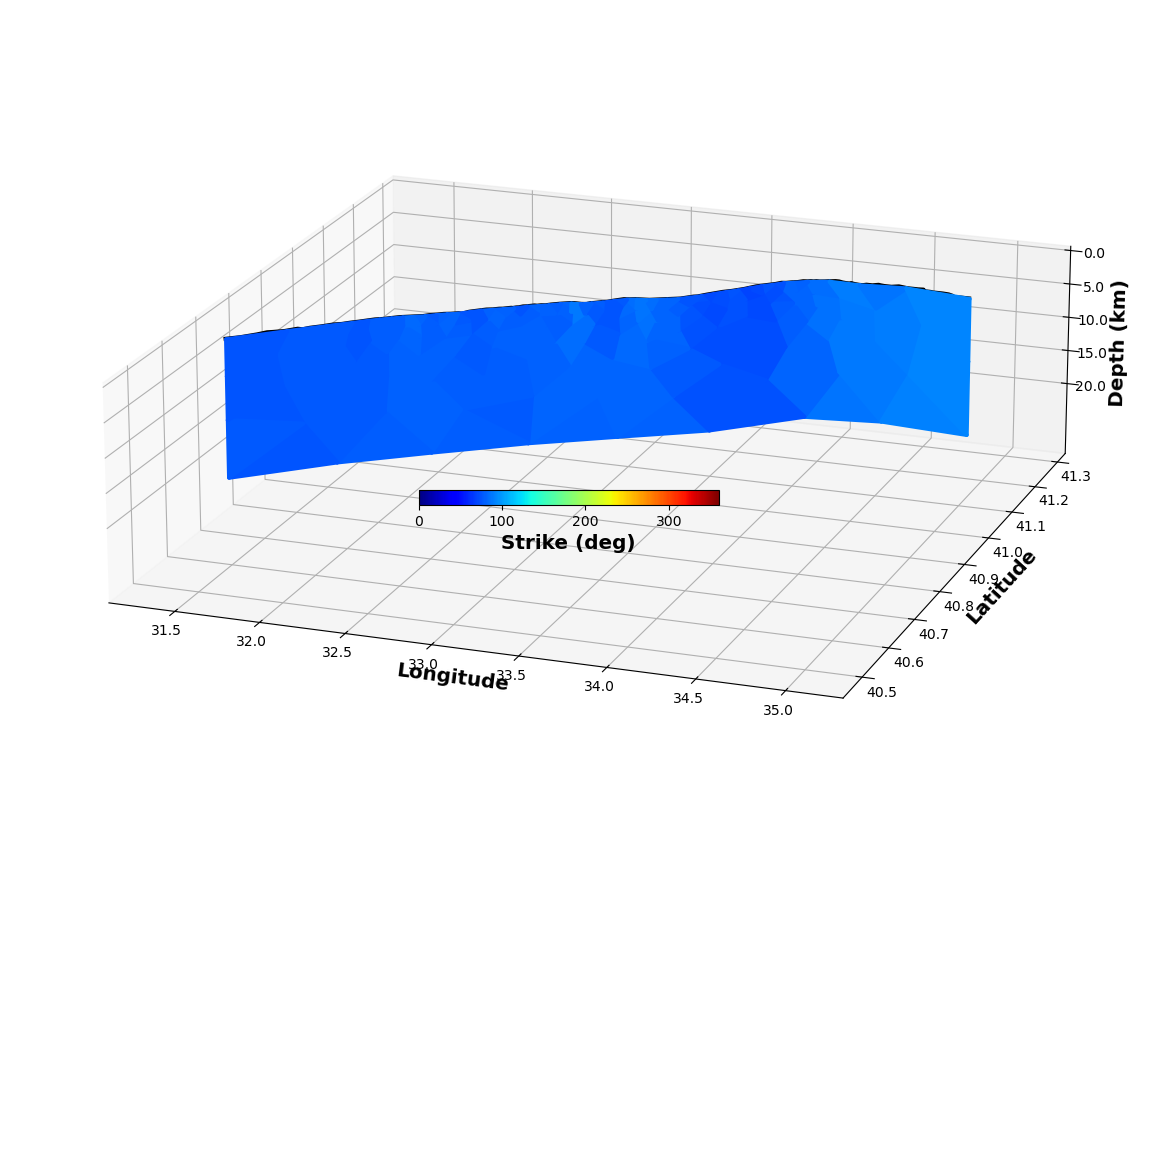

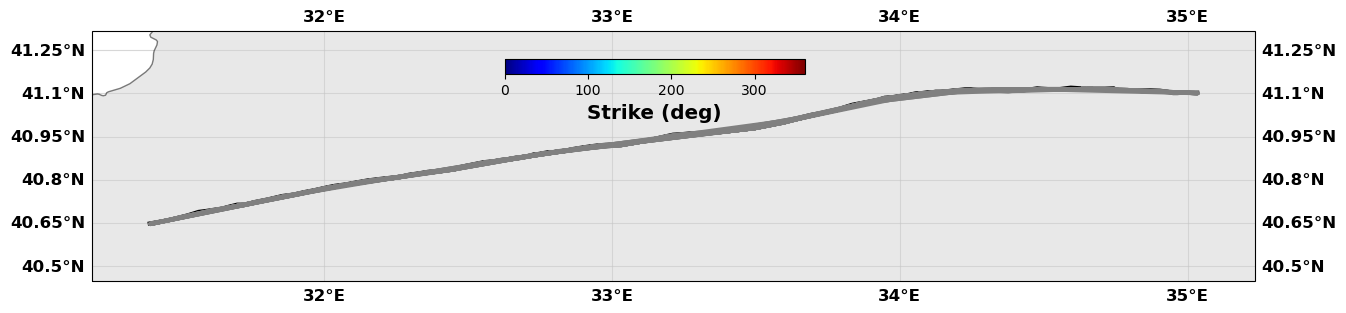

In [21]:
# now we have the mesh, we can populate the fault
naf.Vertices = points
naf.Faces = triangles

# Pass the evrtices from utm to lonlat
naf.vertices2ll()

# Same for patches
naf.patch = [np.array([points[t,:] for t in tri]) for tri in triangles]
naf.patch2ll()

# We enforce the strike to be consistent along strike (we enforce circulation of the vertices of each triangle to be clockwise)
naf.homogeneizeStrike(direction=0, sign=-1.) # Force the normal to point toward the north

# We check the depth
naf.setdepth()

# We force all triangles to be considered vertical
naf.vertical = True

# For plotting purposes we set the slip to be the strike
naf.initializeslip(values='strike')
naf.slip[:,0] *= 180./np.pi

# If you want to write to a file with Gocad format, uncommment
#naf.writeGocadPatches('NAFshortshallow.triangles')
# If you want to write to a text file, uncomment
#naf.writePatches2File('NAFshortshallow.txt') 

naf.plot(slip='strikeslip', drawCoastlines=True, figsize=((15, 15), (15, 15)), norm=(0,360), 
         view={'elevation': 20, 'azimuth': 290, 'shape':(1,1,0.4)}, 
         cblabel='Strike (deg)', cbaxis=[0.4, 0.55, 0.2, 0.01])

## Make a deep root for the fault

---------------------------------
---------------------------------
Initializing fault NAF Root


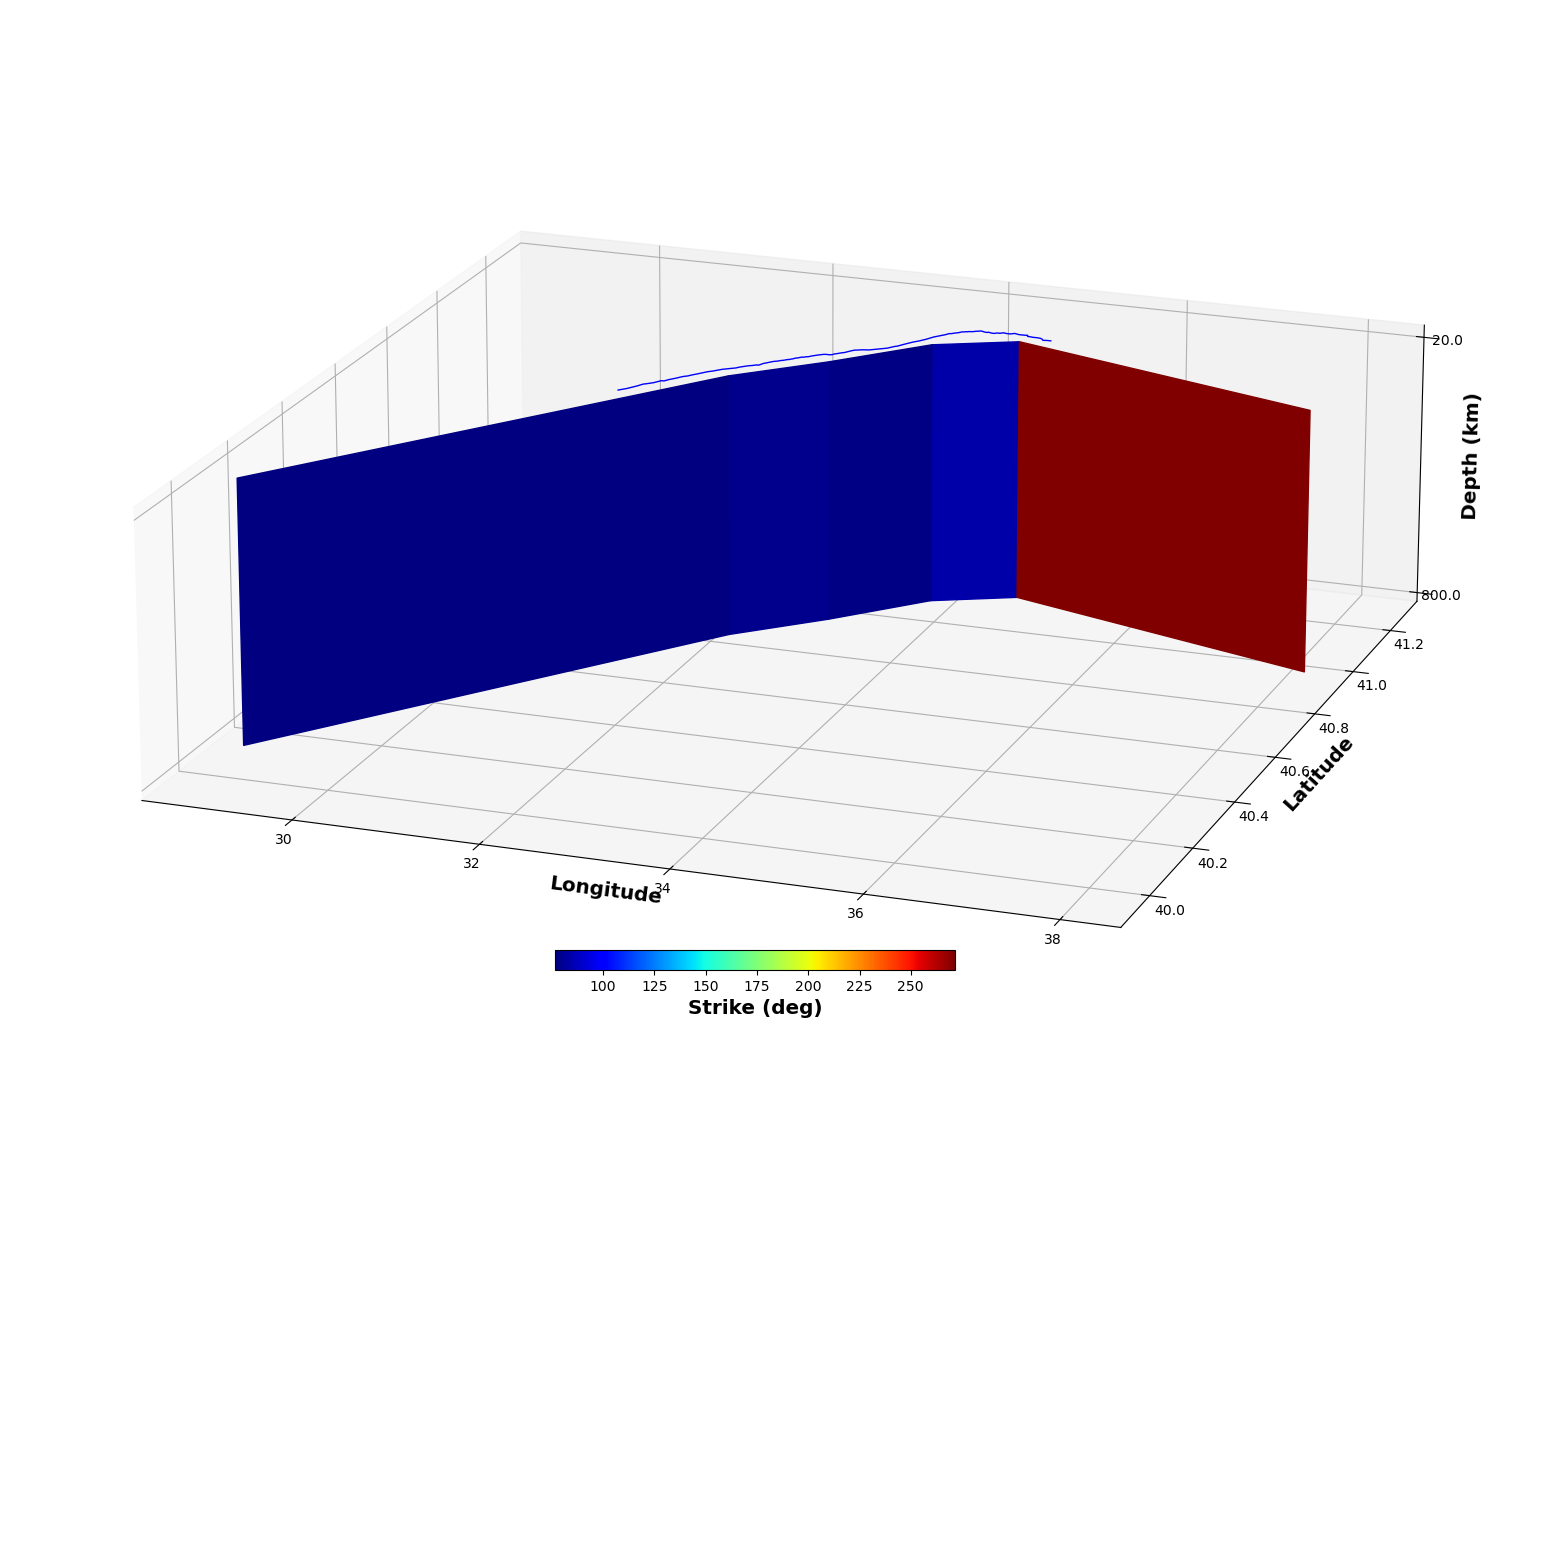

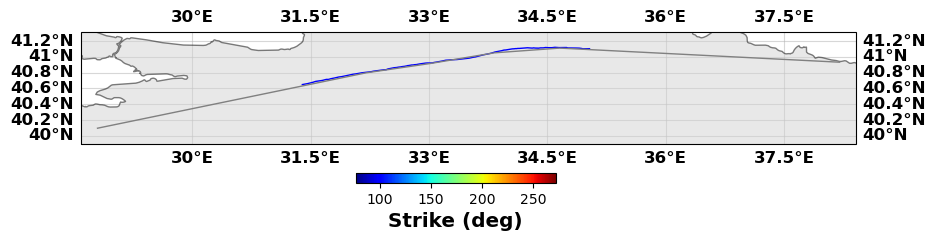

In [24]:
# Create a deep fault
deep = rectflt('NAF Root', lon0=lon0, lat0=lat0)
deep.file2trace(intrace, header=0)

# Plotting
deep.linewidth = 1 
deep.color = 'b'

# Build the deep patches 
deep.setdepth(nump=1, top=depth_max, width=800 - depth_max) # patches between 15 and 800 km deep

# We want a patch every 70 km and the dip angle is to be interpolated between the points provided in dip
deep.buildPatches(dip=[[0., 0., 90.], [0., 1000., 90.], [1000., 1000., 90.]], 
                  every=70., minpatchsize=1., trace_xaxis='x')

# Give me the strike for plotting
deep.initializeslip(values='strike')
deep.slip[:,0] *= 180./np.pi

# Patch number 0 is the one to the west, we want to make it longer for edge effects
deep.horizshrink1patch(0, finallength=300., fixedside='north')

# Patch number 4 is the one to the east, we want to make it long for edge effects
deep.horizshrink1patch(4, finallength=300., fixedside='north')

# If you want to write to a text file, uncomment
#deep.writePatches2File('deepNAF.patches')

# Show me
deep.plot(figsize=[(20,20),(10,10)], view={'elevation': 20, 'azimuth': 290, 'shape':(1,1,0.4)}, cblabel='Strike (deg)', cbaxis=[0.4, 0.4, 0.2, 0.01])

## Make some extensions on the sides

In [25]:
# Create the eastern extension
east = deep.duplicateFault()

# Remove all patches but the easternmost one
east.deletepatches(list(range(4)))

# Plotting stuff
east.linewidth = 1
east.color = 'r'

# Change depth
east.patch[0][0][2] = 0.
east.patch[0][1][2] = 0.
east.patch[0][2][2] = depth_max
east.patch[0][3][2] = depth_max

# Change western boundary
east.patch[0][1][0] = np.max(naf.xf)
east.patch[0][2][0] = np.max(naf.xf)

# Longitude conversion
east.patch2ll()

# Write to file
#east.writePatches2File('eastNAF.patches')

In [26]:
# Create the western extension
west = deep.duplicateFault()

# Plotting
west.linewidth = 1
west.color = 'r'

# Remove all patches but the easternmost one
west.deletepatches(list(range(1,5)))

# Change depth
west.patch[0][0][2] = 0.
west.patch[0][1][2] = 0.
west.patch[0][2][2] = depth_max
west.patch[0][3][2] = depth_max

# Change western boundary
i = np.argmin(naf.xf)
west.patch[0][1][0] = naf.xf[i]
west.patch[0][2][0] = naf.xf[i]
west.patch[0][1][1] = naf.yf[i]
west.patch[0][2][1] = naf.yf[i]

# Longitude conversion
west.patch2ll()

# Write to file
#west.writePatches2File('westNAF.patches')

In [27]:
# The patches are good for computing Green's functions, but they are not nice for plotting. 
# Therefore, we will create new ones for plotting purposes (smaller ones)

# Shrinking patches for plotting. Sizes are chosen so that it is nice
deep.horizshrink1patch(0, finallength=90, fixedside='north')
deep.horizshrink1patch(4, finallength=60, fixedside='north')
for ipatch in range(len(deep.patch)): 
    for ip in range(len(deep.patch[i])): 
        if deep.patch[ipatch][ip][2]>300.: deep.patch[ipatch][ip][2]=30.
        if deep.patchll[ipatch][ip][2]>300.: deep.patchll[ipatch][ip][2]=30.
#deep.writePatches2File('deepNAF.plotpatches')

# East 
for i in range(len(east.patch)): east.horizshrink1patch(i, finallength=26., fixedside='north')
#east.writePatches2File('eastNAF.plotpatches')

# West
for i in range(len(west.patch)): west.horizshrink1patch(i, finallength=20., fixedside='north')
#west.writePatches2File('westNAF.plotpatches')

## Making a nice plot

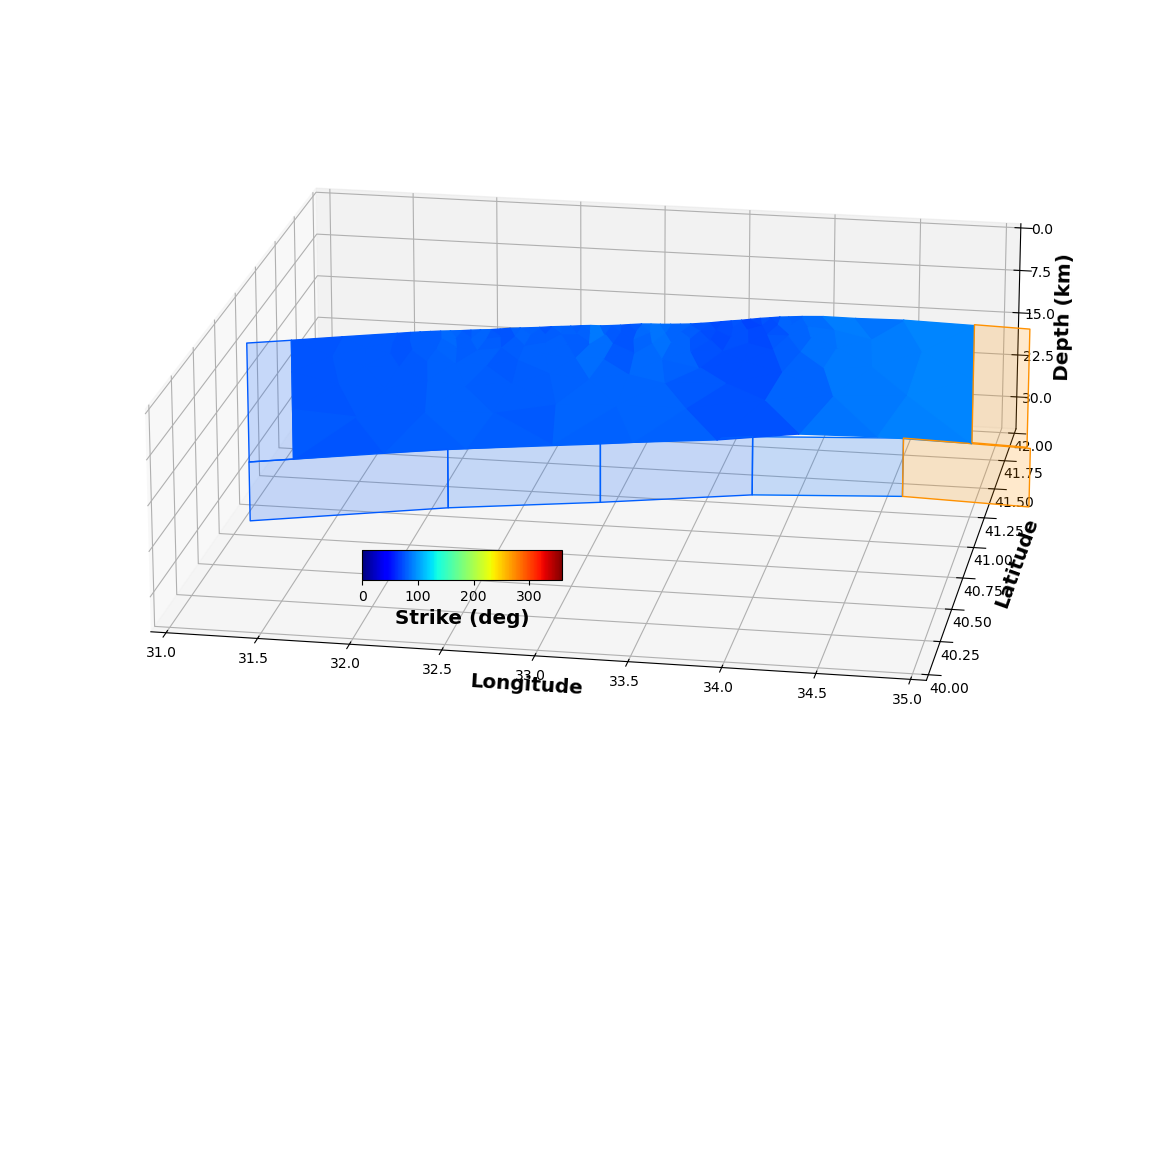

In [40]:
# Plot the whole thing                  
gp = geoplt(31., 40., 35., 42., figsize=((20,15), (20, 15)))
    
# Plot the faults
gp.faultpatches(naf, slip='strikeslip', colorbar=True, zorder=4, plot_on_2d=True, norm=(0, 360), cbaxis=(0.4, 0.5, 0.1, 0.02), cblabel='Strike (deg)')
gp.faultpatches(deep, slip='strikeslip', colorbar=False, alpha=0.2, plot_on_2d=True, norm=(0, 360))
gp.faultpatches(east, slip='strikeslip', colorbar=False, alpha=0.2, plot_on_2d=True, norm=(0, 360))
gp.faultpatches(west, slip='strikeslip', colorbar=False, alpha=0.2, plot_on_2d=True, norm=(0, 360))

# Set views
gp.setzaxis(30.)
gp.set_view(20., 280., shape=[1., 1., 0.4])
gp.show(showFig=['fault'])

That's all folks! Now the only difficulty is to get pydistmesh to compile but I have a working version, trying to push it into GitHub